# 用评分数据来预测热门游戏

这次我们使用 `XGBoost` 算法来进行预测。`XGBoost` 可以用作分类、预测和排序，是一种全面的算法。这次我们使用它来判断某个游戏是否能称为热门。

---

## 0. 背景

玩家玩了游戏之后有时会写评论、评测，也会在社交媒体上留言。这些「口碑」可以帮助我们判断某款游戏是否能成功。不过，并不是有好口碑就能成功，口碑不好的游戏也不见得就一定失败。要预测热门游戏，算法就必须考虑口碑之外的其他属性数据。

我们这次使用的数据是 Metacritic 的数据，包括了专家和用户评测、销售额、ESRB 评级等数据。评测是以 0-10 或者 0-100 的分数呈现。虽然数据维度很多，但这个数据有一个重大缺陷，就是数据量很小。

在机器学习世界里，我们经常都会面临小数据集的问题。小数据集不仅量小，数据的分布还常常不均匀。这时候，我们就需要用到「集成学习」（Ensemble Learning）。在这个笔记本里，我们使用常用的 `XGBoost` 集成学习算法来判断游戏是否能成热门。

---

## 1. 准备工作

### 1.1 参数设置

下面我们设置参数。

- `REGION` = 我们使用的区域，S3 桶和数据应该存放在此区域，SageMaker 训练时也会使用此区域的资源
- `BUCKET` = S3 桶名字，用于存放训练和模型数据，请提前创建好，不包含 `s3://`
- `PREFIX` = S3 前缀（文件夹）名字，所有数据都会放在它下面
- `SOURCE_FILENAME` = 训练数据文件，**请提前下载并存放到上面这个 S3 桶的前缀下，把地址写在这里**


In [162]:
# 设置参数

REGION = '' # 如果留空则自动选择
BUCKET = '000-sagemaker'
PREFIX = 'video-game-sales-xgboost/' # 不要忘记末尾的斜线否则会出错
SOURCE_FILENAME = 'raw/Video_Games_Sales_as_at_22_Dec_2016.csv'

In [163]:
# 尝试自动识别区域

SESSION = boto3.session.Session()

if REGION not in (SESSION.get_available_regions('ec2') + SESSION.get_available_regions('ec2', 'aws-cn')):
    print('[信息] 区域配置有误或未配置，尝试自动识别区域'.format(REGION))
    
    REGION = SESSION.region_name
    if REGION:
        print('[信息] 自动获取到区域：{}'.format(REGION))
    else:
        print('[错误] 未能获取到区域')
else:
    print('[信息] 区域配置：{}'.format(REGION))

[信息] 区域配置有误或未配置，尝试自动识别区域
[信息] 自动获取到区域：cn-northwest-1


### 1.2 导入需要的 Python 库

接下来我们导入一些必须的 Python 库。

In [155]:
# 常用的 Python 库

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from sklearn.datasets import dump_svmlight_file
from time import gmtime, strftime
import sys
import math
import json

# Boto3 就是 AWS SDK 的 Python 版本

import boto3
import botocore

---
## 2. 探索数据

在正式训练之前，我们可以在笔记本内简单地探索数据。

### 2.1 下载数据

我们先把数据文件下载到本地。

In [183]:
# 创建 S3 资源对象

S3 = SESSION.resource('s3', region_name = REGION)

# 下载源数据文件并存为 raw_data.csv

try:
    S3.Bucket(BUCKET).download_file(PREFIX+SOURCE_FILENAME, 'raw_data.csv')
    
    print('[信息] 原始数据下载成功')
except botocore.exceptions.ClientError as error:
    if error.response['Error']['Code'] == '404':
        print('[错误] 文件没找到：{}'.format('s3://{}/{}'.format(BUCKET, SOURCE_FILENAME)))
    else:
        print('[错误] {}'.format(error))

[信息] 原始数据下载成功


### 2.2 展示数据

使用表格来展示数据。

In [173]:
# 用一个表格展示刚刚下载的 CSV 数据

data = pd.read_csv('./raw_data.csv')
pd.set_option('display.max_rows', 20)

# 直接写 data 变量，不用 print()，就可以展示它

data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 确定「热门游戏」的标准

接下来，我们需要确定什么叫「热门」游戏。游戏的开发经常需要成百上千万的投入，只有游戏火了，游戏公司才能把这些成本收回来并盈利。所以，我们这次设置一个比较高的标准，就是全球销量达到 100 万份，才算是「热门游戏」。

In [174]:
# 这是一种比较特殊的语法，意思是：给 data 表增加「y」字段，它的值取决于该行的 Global_Sales 值是否大于 1，这里的 1 代表 100 万
# 这种语法叫做 Boolean Masking，见：https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html
# 实际上这是重载了 Python 的很多操作符用于数组操作，让数组操作变得简洁直观，而且使用了 Numpy 自己的底层实现，比 Python 原生的数组操作更快

data['y'] = (data['Global_Sales'] > 1)

# 打印表格

data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,y
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,True
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,True
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,True
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,True
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,False
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,False
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,False
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,False


### 2.4 用图表分析热门游戏特征

接下来我们用柱状图展示热门和非热门游戏。


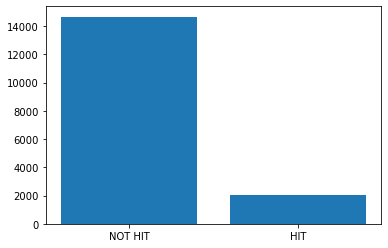

In [168]:
# bar就是柱状图，第一个参数指展示两列，第二个参数指用 y 字段不同值的数量作为输入
# y 字段只能是 False 和 True，前者为 0 而后者为 1，刚好对应数组的位置

plt.bar(['NOT HIT', 'HIT'], data['y'].value_counts())

# 不用下面这句也会展示图，但是会多输出一句 plot 数据类型

plt.show()


可以看出，只有少数游戏能成「热门」，符合常识。

接下来，我们需要选择那些影响游戏热门程度的特征。我们的直觉可能是，评分会影响销量。那我们把这两个值放到一个图上，看看我们的直觉是不是准确。因为值的分布很广，所以我们使用对数尺度。


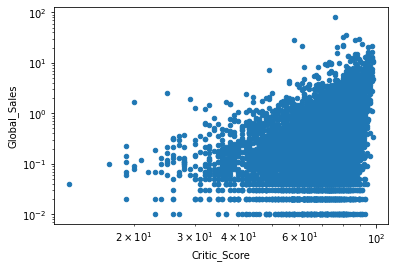

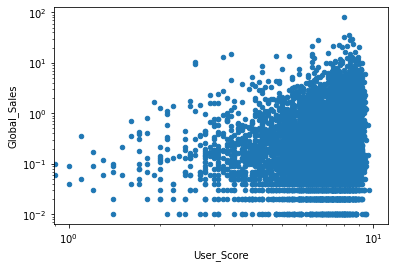

In [169]:
# 只保留用户评分、专家评分和销量三个字段
# df.filter() 用于过滤数据，axis=0 过滤行，axis=1 过滤列

viz = data.filter(['User_Score', 'Critic_Score', 'Global_Sales'], axis=1)

# 原始数据里面用户评分是单个数字，会被读取成 str 类型，所以我们要转换成 int64/float64（自动整数或浮点）
# errors='coerce' 代表如果不能转换就返回特殊值 NaN = Not a Number

viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))

# 接下来处理 NaN 值，如果是 NaN，就取同一行的专家评分值除以 10 作为用户评分值
# 专家评分值是 0-100，用户评分值是 0-10
# df.mask() 函数会遍历数组，对符合条件的字段进行处理
# 其实这一步不处理也没问题，散点图可以接受 NaN 值

viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)

# 创建散点图

viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')

# 不用下面这句也会展示图，但是会多输出一句 plot 数据类型

plt.show()

看来我们的直觉判断是准确的。评分和销量有正向关系。

我们也可以对照销量和数据集中的其他字段（特征）。比如我们可以对照 ESRB 分级和销量的关系。理论上 E 评级代表 Everyone（每个人），那么它面对的受众就会更广泛，而 M 代表 Mature（成人），受众群体就会小一些。但另一个方面，即便是 M 级的游戏，如果游戏类型是射击类或者动作类，也可能成为爆款。我们的模型需要认识这些特征关联关系。


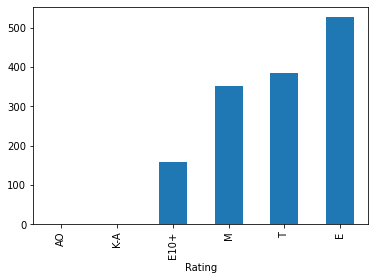

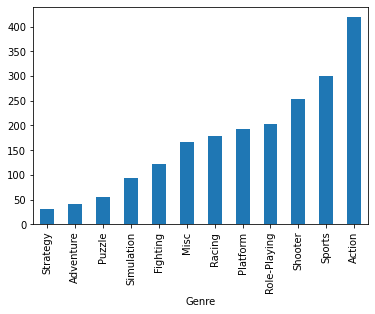

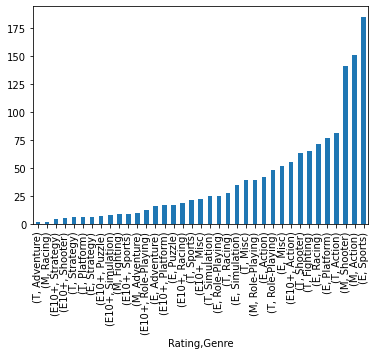

In [170]:
# 检视评级和销量的关系

data[data['y'] == True].groupby('Rating').size().sort_values().plot(kind='bar')
plt.show()

# 检视类型和销量的关系

data[data['y'] == True].groupby('Genre').size().sort_values().plot(kind='bar')
plt.show()

# 检视评级+类型与销量的关系

data[data['y'] == True].groupby(['Rating', 'Genre']).size().where(lambda s: s > 1).dropna().sort_values().plot(kind='bar')
plt.show()

可以看出，E 级的游戏确实最容易出热门，但 M 级和 T 级（Teen，青少年）也还是不错。从类别上看，动作类游戏一骑绝尘，然后是体育和射击类。如果把两个特征联合起来，那么 E 级的体育类游戏是最容易出热门的，然后是 M 级的动作和射击。

---

## 3. 准备数据

接下来我们要把数据进行处理，方便机器学习算法使用。

### 3.1 去除不需要的字段

首先，我们筛查一下数据集中没有统计意义的特征。比如说，销量统计数据的字段是没有意义的，因为我们已经专门用一个 `y` 列来代表这个游戏是不是热门。再比如，游戏的名字，也不在我们本次关心的范围。我们把这些字段去除掉，让数据清爽一些。

In [175]:
# .drop() 方法可以去除部分数据，axis = 1 指的是去除列（字段），axis = 0 则是去除行（此为默认行为，参数为行的索引值）

data = data.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)

data

,Platform,Genre,Publisher,Critic_Score,User_Score,Rating,y
0,Wii,Sports,Nintendo,76.0,8,E,True
1,NES,Platform,Nintendo,NaN,NaN,NaN,True
2,Wii,Racing,Nintendo,82.0,8.3,E,True
3,Wii,Sports,Nintendo,80.0,8,E,True
4,GB,Role-Playing,Nintendo,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...
16714,PS3,Action,Tecmo Koei,NaN,NaN,NaN,False
16715,X360,Sports,Codemasters,NaN,NaN,NaN,False
16716,PSV,Adventure,Idea Factory,NaN,NaN,NaN,False
16717,GBA,Platform,Wanadoo,NaN,NaN,NaN,False


### 3.2 处理缺少必要数据的行

字段减少了之后，我们来看下哪些行缺少必要数据。


In [176]:
# 检查空字段

data.isnull().sum()

Platform           0
Genre              2
Publisher         54
Critic_Score    8582
User_Score      6704
Rating          6769
y                  0
dtype: int64

可以看到，很多游戏都没有用户或专家评分，甚至有的连分级都没有。可惜的是，这些都是跟我们的预测息息相关的关键特征，而且这么大量的数据缺失，我们也没办法很好的去反推（impute），只能把这些行去除。

In [177]:
# 去除带空值的行

data = data.dropna()

data

,Platform,Genre,Publisher,Critic_Score,User_Score,Rating,y
0,Wii,Sports,Nintendo,76.0,8,E,True
2,Wii,Racing,Nintendo,82.0,8.3,E,True
3,Wii,Sports,Nintendo,80.0,8,E,True
6,DS,Platform,Nintendo,89.0,8.5,E,True
7,Wii,Misc,Nintendo,58.0,6.6,E,True
...,...,...,...,...,...,...,...
16699,GBA,Action,Titus,67.0,tbd,E,False
16700,PC,Shooter,Destineer,61.0,5.8,T,False
16701,GC,Puzzle,Ubisoft,53.0,tbd,E,False
16702,DS,Puzzle,Majesco Entertainment,48.0,tbd,E,False


现在我们要解决另一个问题。观察上面的输出，我们会发现 `User_Score` 列有很多 `tbd` 值。这可能是因为这个游戏的评分人数还不足，还不能显示具体的评分。

这明显不是一个合规的数字值，而我们希望 `User_Score` 是一个数字而不是一个分类，所以我们需要把它转换成数字，比如把它换成 `NaN`（Not-a-Number，一种特殊的数字值，用于指代「不是数字但又不得不填入到数字类型字段的值」）。然后我们再看怎么来处理这些 `NaN` 值。

我们已经丢掉大量带空字段的数据，如果再丢数据量就更小了，所以我们要想办法把这些行也利用起来。最粗暴的做法，就是把专家评分值除以 10，作为用户评分值。这是因为用户很多时候会跟风专家，而除以 10 则是因为专家评分是 0 到 100 而用户是 0 到 10。

In [179]:
# 其实前面已经做过类似的操作

new_data = data.copy()

new_data['User_Score'] = data['User_Score'].apply(pd.to_numeric, errors='coerce')
new_data['User_Score'] = data['User_Score'].mask(np.isnan(data['User_Score']), data['Critic_Score'] / 10.0)

# 避免 SettingWithCopyWarning

data = new_data

### 3.4 单热编码

现在我们最后再来处理下数据，把类别特征转换成数字，方便算法读取。这个转换使用「单热编码」（one-hot encoding）。

所谓「单热编码」就是把：

```
{
  Platform = 'Wii',
  Genre = 'Sports'
}

{
  Platform = 'Switch',
  Genre = 'Shooter'
}

```

改成：

```
{
  Platform_Wii = 1,
  Platform_Switch = 0,
  Genre_Sports = 1,
  Genre_Shooter = 0
}


{
  Platform_Wii = 0,
  Platform_Switch = 1,
  Genre_Sports = 0,
  Genre_Shooter = 1
}
```

这样机器学习算法就可以非常方便地进行某个类别值的统计。

In [180]:
# 修改一下 y 值方便做单热编码

data['y'] = data['y'].apply(lambda y: 'yes' if y == True else 'no')

# pd.get_dummies() 可以把数据中的类别数据转换成单热编码

model_data = pd.get_dummies(data)

# 查看下数据

model_data

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Publisher_inXile Entertainment,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T,y_no,y_yes
0,76.0,8.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,82.0,8.3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,80.0,8.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,89.0,8.5,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,58.0,6.6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16699,67.0,6.7,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
16700,61.0,5.8,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
16701,53.0,5.3,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
16702,48.0,4.8,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### 3.5 拆分数据到不同的组

为了防止过拟合问题，我们把这些数据随机拆分到 3 个组里面。

我们使用 70% 的数据来训练，然后再用 20% 来做验证。这 20% 的数据代表「新」数据，即模型没有见过的数据。我们希望模型既能够很好的应对训练数据，也能很好地应对没见过的数据（这也就是所谓的「预测」）。

最后还有 10% 的数据是我们的最终测试数据集。如果模型不仅「记住」了训练数据，还「记住」了验证数据，至少我还有一套数据是可以来验证模型效果的。


In [181]:
# 用 np.split 来拆分数据

train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   

print('[信息] 拆分成功')

### 3.6 转换成 LibSVM 格式

XGBoost 算法使用 LibSVM 格式的数据，特征和目标变量会被放到两个列表中，形成两个参数。为了特征和目标变量不匹配，我们必须在前面的拆分完成之后，再转换格式。


In [182]:
# 我们把 y_yes 和 y_no 从数据中剔除，作为特征列表，然后选择 y_yes 字段作为目标变量列表，然后存成文件

dump_svmlight_file(X=train_data.drop(['y_no', 'y_yes'], axis=1), y=train_data['y_yes'], f='train.libsvm')
dump_svmlight_file(X=validation_data.drop(['y_no', 'y_yes'], axis=1), y=validation_data['y_yes'], f='validation.libsvm')
dump_svmlight_file(X=test_data.drop(['y_no', 'y_yes'], axis=1), y=test_data['y_yes'], f='test.libsvm')

print('[信息] 数据集 LibSVM 格式转换成功')

### 3.7 上传 S3

在训练之前，我们需要把训练、验证的数据放到 S3 上。SageMaker 使用 S3 作为数据的输入。


In [185]:
# 上传到 S3 的不同前缀下

S3.Bucket(BUCKET).Object(PREFIX + 'train/train.libsvm').upload_file('train.libsvm')
S3.Bucket(BUCKET).Object(PREFIX + 'validation/validation.libsvm').upload_file('validation.libsvm')

print('[信息] 训练和验证数据集上传成功')

[信息] 上传成功


---
## 4. 训练

接下来，我们开始做训练。

In [190]:
from time import time
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker import image_uris

# 获取算法镜像地址和 SageMaker 执行角色

CONTAINER_IMAGE = image_uris.retrieve(framework='xgboost', region=REGION, version='1.2-1')
ROLE = get_execution_role()

# 创建「评估器」，即 SageMaker 封装出来的模型训练器

ESTIMATOR = Estimator(
    image_uri = CONTAINER_IMAGE,   # 算法容器镜像地址
    role = ROLE,         # SageMaker 服务角色
    instance_count = 1,  # 训练实例数量
    instance_type = 'ml.p3.2xlarge', # 实例类型
    volume_size = 50,    # 本地盘大小（GB）
    max_run = 1800,      # 最长运行时间
    use_spot_instances = True,  # 一个参数直接使用竞价实例
    max_wait = 7200,     # 最长等待时间 = 最长运行时间 + 等待竞价实例时间，所以要 ≥ max_run
    input_mode = 'File', # 输入类型 File = 文件，Pipe = 流式
    output_path = 's3://{}/{}output'.format(BUCKET, PREFIX) # 输出的模型会放在这里
)

# 设置静态超参数，超参的理解不在本次范围

ESTIMATOR.set_hyperparameters(
    max_depth = 3,
    eta = 0.1,
    eval_metric = 'auc',
    scale_pos_weight = 2.0,
    subsample = 0.5,
    objective = 'binary:logistic',
    num_round = 100
)

S3_TRAIN_PATH = 's3://{}/{}train/'.format(BUCKET, PREFIX)
S3_VALIDATION_PATH = 's3://{}/{}validation/'.format(BUCKET, PREFIX)

TRAINING_DATA_SOURCE = TrainingInput(
    S3_TRAIN_PATH, 
    distribution = 'FullyReplicated', # FullyReplicated = 在每个节点复制一份完整的（训练/验证）数据
    content_type = 'text/libsvm',     # 输入格式用 MIME 表示
    s3_data_type = 'S3Prefix'         # S3Prefix = 把某个前缀下的所有文件用于训练，否则指向 Manifeso 文件定义实际训练数据位置
)

VALIDATION_DATA_SOURCE = TrainingInput(
    S3_VALIDATION_PATH,
    distribution = 'FullyReplicated', 
    content_type = 'text/libsvm', 
    s3_data_type = 'S3Prefix'
)

INPUTS = {
    'train': TRAINING_DATA_SOURCE, 
    'validation': VALIDATION_DATA_SOURCE
}

# 使用 fit() 方法来开始训练

training_result = ESTIMATOR.fit(
    inputs = INPUTS
)

print('[信息] 训练已完成。')

2021-06-15 09:56:40 Starting - Starting the training job...
2021-06-15 09:56:41 Starting - Launching requested ML instancesProfilerReport-1623751000: InProgress
......
2021-06-15 09:58:00 Starting - Preparing the instances for training............
2021-06-15 09:59:58 Downloading - Downloading input data
2021-06-15 09:59:58 Training - Downloading the training image...
2021-06-15 10:00:38 Training - Training image download completed. Training in progress..[2021-06-15 10:00:39.608 ip-10-0-97-130.cn-northwest-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:r

---

## 5. 部署

现在，我们要把训练好的模型部署到推理节点。

因为我们之前已经做完了训练，`Estimator` 对象还存留有刚刚训练完的任务的信息，所以只需要调用一次 `Estimator.deploy()` 函数，即可直接进行推理节点部署。


In [197]:
ENDPOINT_NAME = 'videogames-xgboost'

# 部署

deployment_result = ESTIMATOR.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.c5.2xlarge',
    endpoint_name = ENDPOINT_NAME
)

print('[信息] 推理节点部署成功')

-----------![信息] 推理节点部署成功


---

## 6. 模型评估

现在我们已经创建好了推理节点，可以做一些评估测试了。


### 6.1 用保留测试数据集来测试模型效果

测试的方式主要是用我们前面留存下来的 10% 的数据来看看我们的模型能多大程度上根据它没有见过的数据来做判断。

In [199]:
# 这里暂时沿用原笔记本的 Boto3 API，实际上 SageMaker 有封装更好的高级 API
# TODO：待改造

RUNTIME = boto3.client('runtime.sagemaker')


In [198]:
# 单次预测

def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = RUNTIME.invoke_endpoint(
        EndpointName = endpoint_name, 
        ContentType = content_type, 
        Body = payload
    )
    
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    
    return preds

# 批量预测

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [202]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]

print(len(test_data))

preds = batch_predict(test_data, 100, ENDPOINT_NAME, 'text/x-libsvm')

print(
    '\n错误率 = {}'.format( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) / float(len(preds)))
)

803
.........
错误率 = 0.1444582814445828
CPU times: user 41.7 ms, sys: 0 ns, total: 41.7 ms
Wall time: 139 ms


### 用混淆矩阵分析结果

评估模型的效果有很多种方式。我们简单地用二分法来表示预测结果，即 `1` 代表预测正确，`0` 代表预测错误。然后我们生成一个混淆矩阵（confusion matrix），把预测结果和实际结果在一张表上展示。

In [201]:
# pandas.crosstab() 可以生成混淆矩阵

pd.crosstab(
    index = np.array(labels), 
    columns = np.array(preds)
)

col_0,0,1
row_0,,
0,616,55
1,61,71


我们这样解读混淆矩阵。横向是实际情况，纵向是模型的判断。

- 左上角的格子 = 实际不是热门，模型也判断不是热门（真阴性）
- 右上角的格子 = 实际不是热门，但模型判断是热门（假阳性）
- 左下角的格子 = 实际是热门，但模型判断不是热门（假阴性）
- 右下角的格子 = 实际是热门，模型也判断是热门（真阳性）

然后，模型有两个比较常见的评判指标：

- 召回率（Recall）= 简单理解就是「宁可错杀倾向」，召回率越高，意味着模型没有漏掉一个真阳性，而代价就是它可能会把一些阴性的也判断成阳性
  - 召回率 = 真阳性 / （真阳性 + 假阴性）
  - 提高召回率就要降低假阴性
  - 假阴性本来应该是阳性，之所以被判断成阴性是因为判断条件太严格了，所以要放宽阳性的标准
  - 但一旦放宽阳性标准，就可能会产生一些假阳性
  - 假阳性不会在召回率中体现，所以如果刻意提升召回率很可能会造成假阳性增多
- 准确率（Precision）= 简单理解就是「绝不错杀倾向」，准确率越高，意味着只要模型说它是阳性，它就是阳性，而代价则是它可能会把一些本来是阳性的判断成阴性
  - 准确率 = 真阳性 / （真阳性 + 假阳性）
  - 要提升准确率就要降低假阳性
  - 假阳性太高是因为标准太宽松，所以要把阳性标准设置更严格
  - 标准一旦严格，就会把一些本来应该是阳性的漏掉，产生一些假阴性
  - 但假阴性不在准确率中体现，所以如果刻意提升准确率就可能会造成假阴性增多

可见，二者是不可调和的，训练的目标是在这些指标中寻找一个平衡点。

机器学习每次训练会生成随机数作为神经网络初始化的一部分，所以每次训练的结果都不同。通常我们会看到大概 70 多个真阳性。总体判断错误大概会在 13-15% 左右。

如果调整 `scale_pos_weight`，我们就可以剧烈地干预假阴性和真阳性之间的比率。当然，这样做的结果就是错误率升高，以及随之而来的更多的假阳性。是否要调整，如何调整，就要看我们业务上的偏好和需要了。


---
## 结束

本次工作坊就到这里。谢谢大家！